In [1]:
#The following will time the execution of the whole notebook:
import time
start_time = time.time()

In [2]:
def hms(seconds):
    # Convert timings to human-readable format
    h = seconds // 3600
    m = seconds % 3600 // 60
    s = seconds % 3600 % 60
    return f'{h:.2f} hours, {m:0.2f} minutes and {s:0.2f} seconds.'

# Introduction to AI in Drug Discovery

Here we will lookl at a couple of examples of application of Deep Learning methods in Drug Discovery.

1. First, we will use a *Molecular Generator* to generate new (random) molecules
1. Second, we will look at how we can use AI to predict a relevant molecular property.  
1. Finally, we will combine the two things to optimize the property in generated molecules

## Load Generic Packages

Here we will load the generic packages we will need for this exercise. Specific packages will be loaded as needed.


**Environment Check**

The commands below are *not* really necessary, as the `pytorch` package is imported as needed by other libraries. However, the AI programs we'll use require a CUDA-enabled GPU, so here we test your environment before we start. If all is OK (meaning you do have access to a CUDA-enabled GPU and the correct libraries are installed), the result should print `True`. If you see any other output, check your environment.

In [3]:
import torch
torch.cuda.is_available()

True

**Standard Python Libraries**

Now that we know the environment is OK, we can go on to load the standard libraries

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tnrange, notebook

**Chemistry-Specific Package: RDKit**

Here we will use a package designed specifically to deal with molecules: [RDKit](www.rdkit.org):

In [5]:
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
print("RDKit Version: ", rdkit.__version__)

import ReLeaSE

RDKit Version:  2024.09.1


/blue/lic/seabra/.conda/envs/IntroAIPharma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RDKit allows us to represent the molecules using the *"Simplified Molecular Input Line Entry System"*, or [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). This is a molecular representation created by [Daylight Chemical Information Systems](https://www.daylight.com/) to represent molecules in a simplified format as a sequence of text characters.

For example, the antibiotic [Ciprofloxacin](https://pubchem.ncbi.nlm.nih.gov/compound/2764) can be represented in SMILES format as: "C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O". We can use RDKit to visualize it in 2D with:

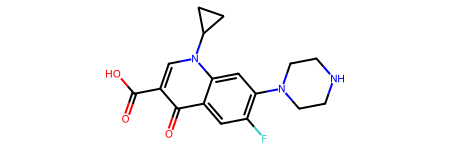

In [6]:
Chem.MolFromSmiles("C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O")

For details, look into the Wikipedia site [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), or the Daylight site [here](https://www.daylight.com/smiles/).

Now that the basic libraries are loaded, let's try some AI.

**Check current directory**

The result should be `/blue/pha6467/<your_username>/IntroAIPharma/workshop` 

In [7]:
!pwd

/blue/lic/seabra/teaching/IntroAIPharma/workshop


**Copy large files**

These files are too large for GitHub, we copy them manually here.

## 1. Generating New Molecules

You have probably seen AI being used to generate text (e.g. [Google Bard](https://bard.google.com/), [ChatGPT](https://openai.com/chatgpt)), images (e.g. [MidJourney](https://www.midjourney.com/)) and even videos (e.g. [Runway](https://runwayml.com/))

AI can also be used to generate molecules! In this exercise, we will use a molecular generator adapted from the ReLeaSE code, for "<u>Re</u>inforcement <u>Lea</u>rning for <u>S</u>tructural <u>E</u>volution". The original code is available [here](https://github.com/isayev/ReLeaSE). For more details, see the original publication:

> Mariya Popova, Olexandr Isayev, Alexander Tropsha. _Deep Reinforcement Learning for de-novo Drug Design_, Science Advances, **2018**, Vol. 4, no. 7, eaap7885. DOI: [10.1126/sciadv.aap7885](http://dx.doi.org/10.1126/sciadv.aap7885)

Our implementation includes some slght modifications to include in this notebook. First, lets define the properties we want for this generator:

In [8]:
%time
generator_properties = {
    'name':'ReLeaSE',    # Just a name to remeber what generator we are using
    'batch_size':200,    # Generate this many molecules at a time, unless we specify the desired number
    'initial_state':'release/checkpoints/generator/checkpoint_biggest_rnn' # The unbiased state of the generator
}
generator = ReLeaSE.ReLeaSE(generator_properties)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs
Initializing the generator. Please wait a minute...
--> data_path =  release/data/chembl_22_clean_1576904_sorted_std_final.smi
--> tokens    =  ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']', '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
Generator ready to be used. Elapsed time: 27.18 seconds.

Loading generator from file release/checkpoints/generator/checkpoint_biggest_rnn ... 

/blue/lic/seabra/teaching/IntroAIPharma/workshop/release/stackRNN.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(path)


Done.


... and now we have our molecular generator initialized. Notice we did read an initial "state" for the generator, from the file in `release/checkpoints/generator/checkpoint_biggest_rnn`. Here, it was trained with ~1.5 Million molecules obtained from the [ChEMBL database](https://www.ebi.ac.uk/chembl/) v21, to generate valid, drug-like molecules.recovery

In our version of the generator, we can define the number of molecules to generate with the parameter `n_to_generate`. ReLeaSE always generate the molecules as SMILES strings, but we can recover them  either as SMILES strings or as RDKit ROMol objects, which is the way RDKit represents the molecules internally.

For example, to generate 10 unique, random molecules and receive them in SMILES notation:

In [9]:
smis = generator.generate_smis(10)

Generated    : 21
Valid SMILES : 10 (47.62% of the total)
Unique SMILES: 10 (47.62% of the total)


Here, to get 10 unique valid molecules it generated a larger number of SMILES strings, as some of those didn't translate to valid molecules. The number of generated SMILES and percent validity may vary each time you run this cell.

We can now use RDKit to look into the generated molecules. First, we need to convert the molecules from SMILES to ROMol format (the RDKit molecule format), and then we can visualize them:

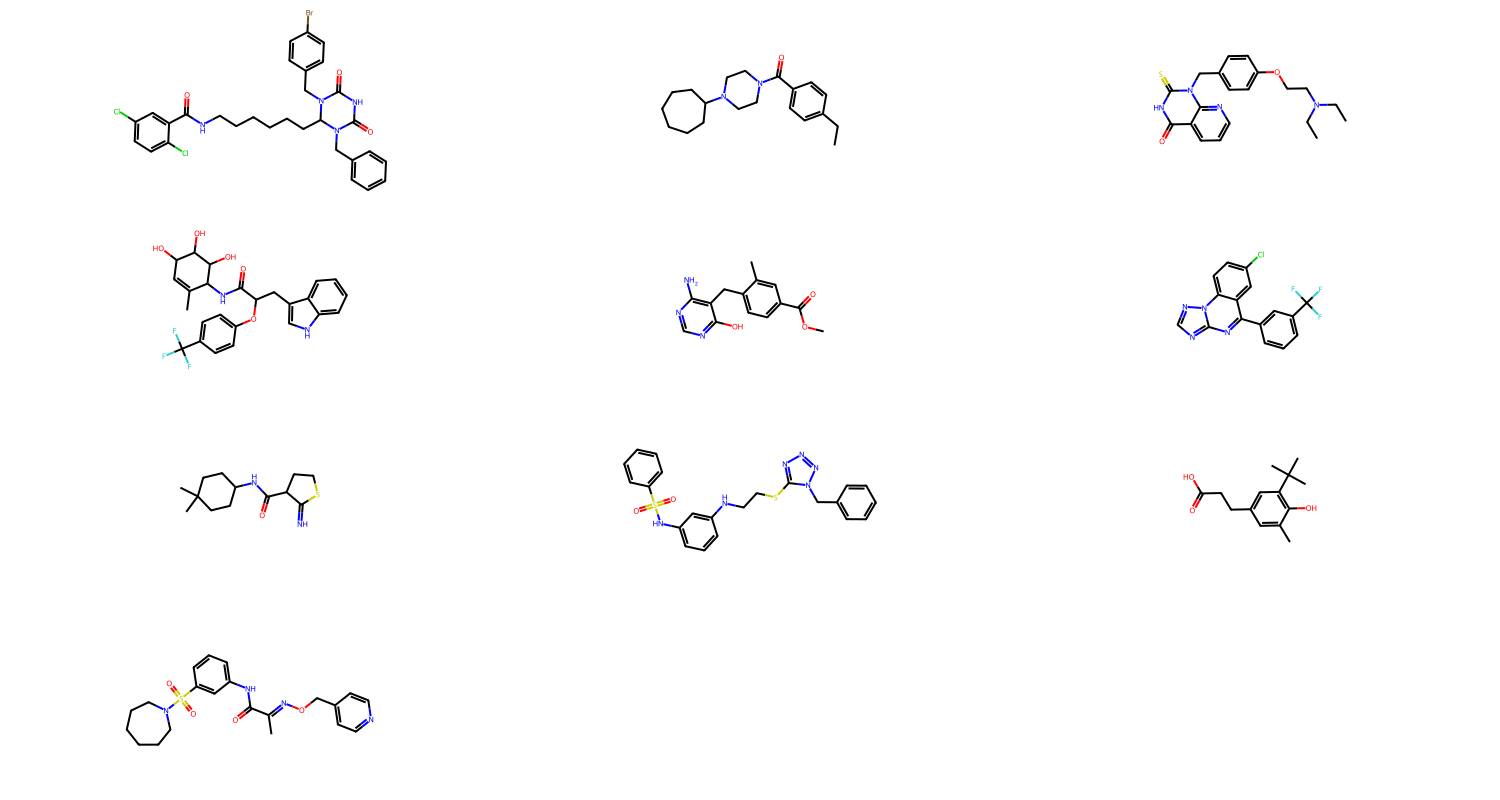

In [10]:
# Draw Random Generated Molecules
mols = [Chem.MolFromSmiles(s) for s in smis]
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200))

We can also get the molecules directly in the ROMol format:

In [11]:
%time
mols = generator.generate_mols(10)

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 3.58 μs


Generated    : 13
Valid SMILES : 10 (76.92% of the total)
Unique SMILES: 10 (76.92% of the total)


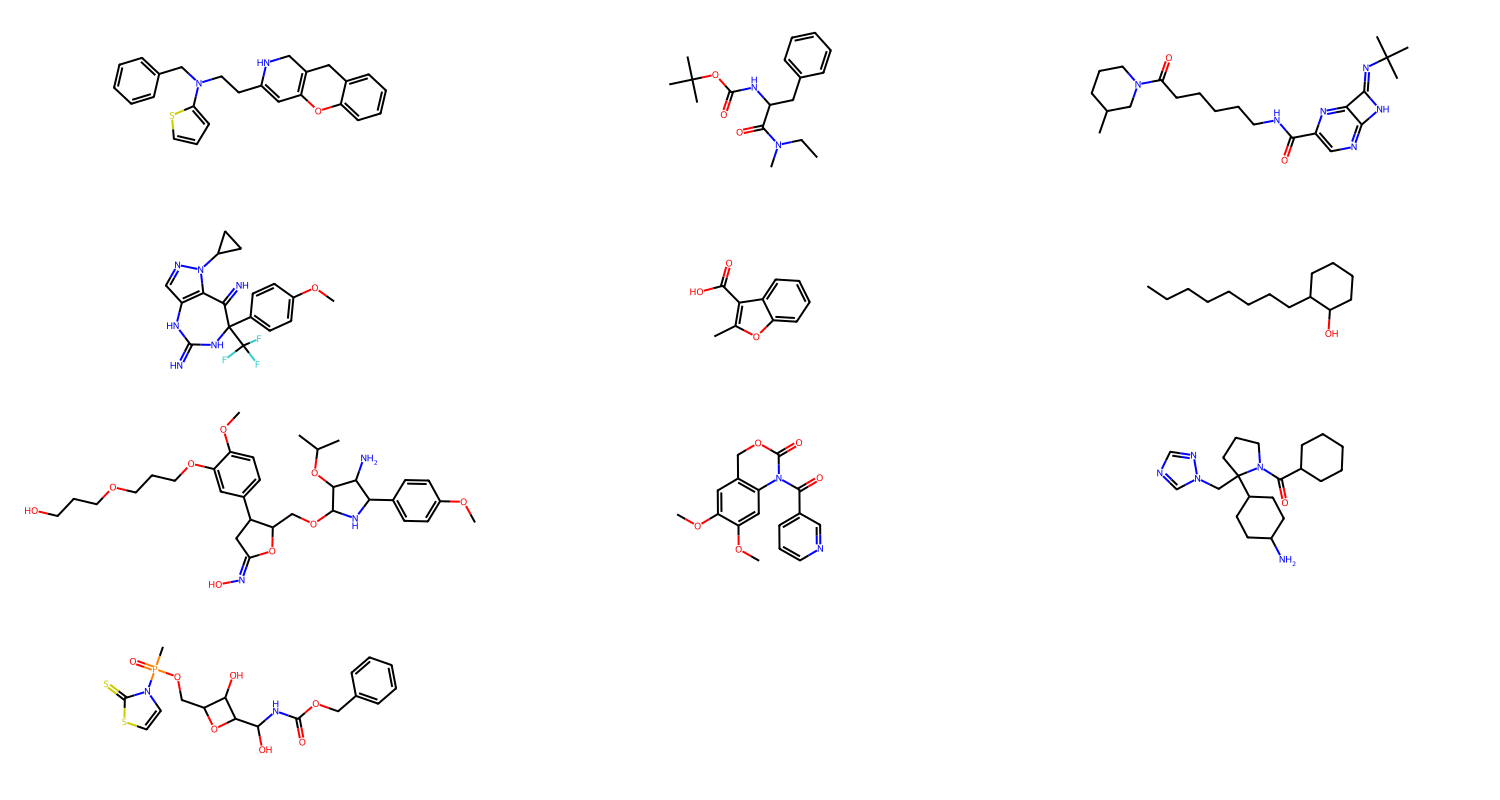

In [12]:
# Draw Random Generated Molecules
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200))

And there you go, you just used a molecular generator to create new, random molecules!

## 2. Estimation of Molecular Properties

You already can generate random molecules. Now, imagine you are part of a team designing a new drug for Alzheimer's disease. You want this drug to be able to reach receptors in the brain, so penetration of the [Blood-Brain Barrier](https://en.wikipedia.org/wiki/Blood%E2%80%93brain_barrier) (BBB) is important. But how can you know if a generated molecule is able to cross the BBB?

Here we will create a deep-learning model to predict the BBB penetration, based on the SMILES string for a given molecule. For that, we will be using the CHEM-BERT model, which original code is available [here](https://github.com/HyunSeobKim/CHEM-BERT), and published in Nature Scientific Reports:

> Hyunseob Kim, Jeongcheol Lee, Sunil Ahn & Jongsuk Ruth Lee, *A merged molecular representation learning for molecular properties prediction with a web-based service*, Scientific Reports, **2021**, volume 11, Article number: 11028 [DOI:10.1038/s41598-021-90259-7](https://doi.org/10.1038/s41598-021-90259-7)

CHEM-BERT is a model based on Bidirectional Encoder Representations from Transformers ([BERT](https://en.wikipedia.org/wiki/BERT_(language_model))), a family of models developed for language tasks. In CHEM-BERT, the transformer was pre-trained to predict masked tokens of SMILES strings, and at the same time predict the value of the "Quantitative Estimate of Drug-Likeness" (QED) for a set of 9 million molecules from the ZINC database. QED estimates 8 different molecular properties:

* ALOGP = Octanol / water partition coefficient
* HBx = H-Bond Donor/Acceptor
* PSA = Polar Surface Area
* ROTBs = Number of Rotatable Bonds
* AROMS = Number of aromatic groups
* ALERTS = Number of structural alerts: 94 functional moieties that are potentially mutagenic, reactive or have unfavourable pharmacokinetic properties
* MW = Molecular weight

and combines them to generate one number in the 0-1 interval that relates to the concept of "drug-likeness". The inclusion of QED values in the training helps the model to learn a SMILES representation merged with chemical context.

After the pre-trained, the CHEM-BERT model can then be fine-tuned to predict other properties of compounds.

Here, we will fine-tune the CHEM-BERT model to predict the BBB penetration of compunds. As input, we will use the B3DB set available [here](https://github.com/theochem/B3DB/tree/main), and published in:
> Meng, F., Xi, Y., Huang, J. et al. _A curated diverse molecular database of blood-brain barrier permeability with chemical descriptors._ Sci Data **(2021)** 8, 289. [DOI:10.1038/s41597-021-01069-5](https://doi.org/10.1038/s41597-021-01069-5)

This includes curated $\log{BB}$ data for 1,058 compounds from the literature, where

$$ \log \;BB=\log \frac{{C}_{brain}}{{C}_{blood}} $$

In general, a compound is considered to penetrate the BBB if the $\log{BB} > -1$.

However, the dataset also has *categorical* data, where the molecules can be simply separated as "BBB+" (able to cross the BBB) or "BBB-".

Let's take a look at the dataset.

In [13]:
b3db = pd.read_csv("data/B3DB_classification.tsv", delimiter='\t')
b3db.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN
3,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,CCNC(=NCCSCc1ncccc1Br)NC#N,14022517.0,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,NaN,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,NaN
4,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,18595497.0,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,NaN,R25|,A,NaN


In [14]:
len(b3db)

7807

Notice that some columns have "NaN" as data for some compounds, meaning that this specific data point is missing.

To get a list of all the columns present in the dataset:

In [15]:
b3db.columns

Index(['NO.', 'compound_name', 'IUPAC_name', 'SMILES', 'CID', 'logBB',
       'BBB+/BBB-', 'Inchi', 'threshold', 'reference', 'group', 'comments'],
      dtype='object')

The columns that are important for us are `SMILES` and `logBB`. Let's check if there are any missing values:

In [16]:
# Check for missing values or SMILES
print("Are there missing SMILES?          ", b3db.SMILES.isna().any())
print("Are there missing logBB values?    ", b3db.logBB.isna().any() )
print("Are there missing category values? ", b3db['BBB+/BBB-'].isna().any() )

Are there missing SMILES?           False
Are there missing logBB values?     True
Are there missing category values?  False


Lets look at the distribution of numeerical ($\log{BB}$) values. Remember, values of $\log{BB} > -1$ are considered to penetrate the barrier, written as *BBB+*.

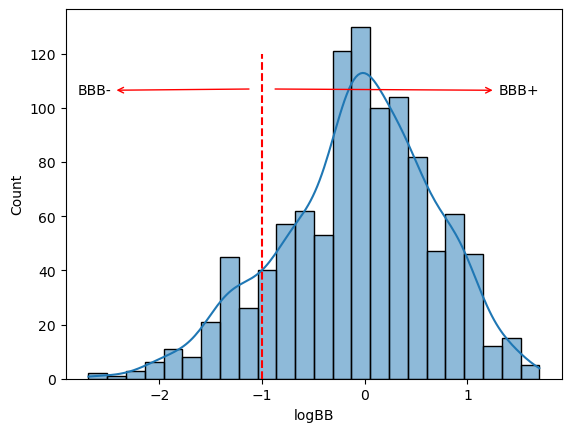

In [17]:
fig, ax = plt.subplots()
ax=sns.histplot(data=b3db, x='logBB', kde=True)
threshold = -1.0
plt.vlines(threshold,0,120,color='red', ls='--')
plt.annotate('BBB+',(threshold + 0.1,107), (1.3,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
plt.annotate('BBB-',(threshold - 0.1,107), (-2.8,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );

Notice that this dataset is unbalanced, as there are many more "BBB+" than "BBB-" molecules.

In [18]:
n_BBB_plus  = sum(b3db.logBB >= -1)
n_BBB_minus = sum(b3db.logBB < -1)
print(f"Number of BBB+ molecules: {n_BBB_plus} ({ n_BBB_plus /(n_BBB_plus + n_BBB_minus):0.1%}) ")
print(f"Number of BBB- molecules: {n_BBB_minus} ({n_BBB_minus/(n_BBB_plus + n_BBB_minus):0.1%}) ")

Number of BBB+ molecules: 930 (87.9%) 
Number of BBB- molecules: 128 (12.1%) 


This, unfortunately, is a result of the literature bias: Researchers studying molecules that penetrate the BBB are more likely to publish results of the successful molecules, while researchers studying systems where BBB crossing is not an issue don't even bother to measure $\log{BB}$. In the end, the literature has this imbalance in the available data.

Now, let's look at the categorical data:

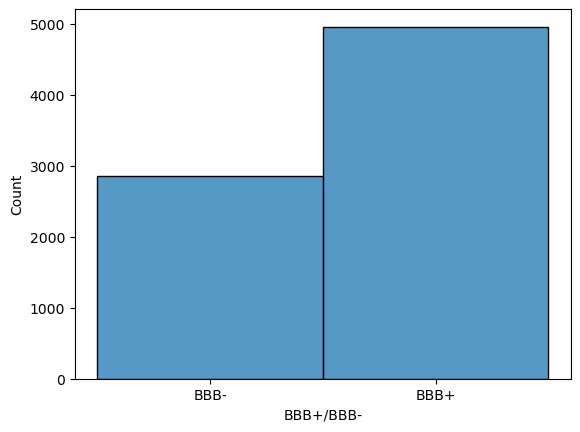

In [19]:
fig, ax = plt.subplots()
ax=sns.histplot(data=b3db, x='BBB+/BBB-')

In [20]:
n_BBB_plus  = sum(b3db['BBB+/BBB-'] == "BBB+")
n_BBB_minus = sum(b3db['BBB+/BBB-'] == "BBB-")
print(f"Number of BBB+ molecules: {n_BBB_plus} ({ n_BBB_plus /(n_BBB_plus + n_BBB_minus):0.1%}) ")
print(f"Number of BBB- molecules: {n_BBB_minus} ({n_BBB_minus/(n_BBB_plus + n_BBB_minus):0.1%}) ")

Number of BBB+ molecules: 4956 (63.5%) 
Number of BBB- molecules: 2851 (36.5%) 


That looks like a better distribution. Now let's use it to fine-tune CHEM-BERT with it. That's OK, because in most scenarios, researchers actually try to predict *if* a molecule will or not cross the BBB. To predict that, let's create a dataset with labels "1.0" for BBB+ molecules, and "0.0" for BBB-:

In [21]:
logbb_data = pd.DataFrame({'SMILES':b3db.SMILES,
                           'LABELS':[1.0 if x == "BBB+" else 0.0 for x in b3db['BBB+/BBB-'].values]})
logbb_data

,SMILES,LABELS
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0.0
2,Oc1c(I)cc(Cl)c2cccnc12,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0.0
...,...,...
7802,c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1,0.0
7803,CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21,1.0
7804,CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1,1.0
7805,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1,0.0


### Creating a CHEM-BERT Model

Now we can create a CHEM-BERT model for predicting if a molecule will fall into the BBB+ or BBB- category.

In [22]:
from CHEMBERT import finetune_CHEMBERT

Here we are using CHEM-BERT as a classifier.

In fact, CHEM-BERT will predict a number between 0-1, indicating a probability that a molecule will fall into the 0 or 1 category. In the process below, notice how it begins by just guesing "1" for all molecules, but slowly changes the predictions to get the BBB- molecules correctly.

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs
############################################################
                 FINE-TUNING CHEMBERT MODEL                 
############################################################
Pre-trained model: /blue/lic/seabra/teaching/IntroAIPharma/workshop/CHEMBERT/model/pretrained_model.pt
Task =  classification
Maximum time =  720


Final split sizes:
Training set:       6,245
Testing set:          781
Validation set:       781


/blue/lic/seabra/.conda/envs/IntroAIPharma/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/blue/lic/seabra/teaching/IntroAIPharma/workshop/CHEMBERT/finetune_CHEMBERT.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling.

Classification task. Criterion = BCEWithLogitsLoss

         FINETUNING MODEL          
Attempting up to 4 epochs, or 720 minutes.

Epoch 1 of a maximum of 4.


Training  :  20%|█████▋                      | 20/98 [00:20<00:26,  2.95batch/s][19:23:13] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


Training  :  89%|████████████████████████▊   | 87/98 [00:42<00:03,  3.00batch/s][19:23:36] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCC[C@H](OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


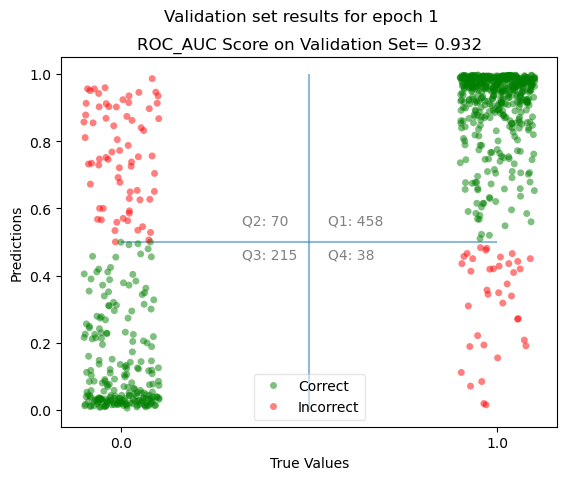

ROC_AUC Score on Test Set       = 0.913
Validation loss improved, saving new model to: chembert/Finetuned_model_1.pt
Epoch time:   0.0 minutes.
Elapsed time: 0.0 minutes out of a maximum of 720.

Epoch 2 of a maximum of 4.


Training  :  81%|██████████████████████▌     | 79/98 [00:26<00:06,  3.00batch/s][19:24:10] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCC[C@H](OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


Training  :  86%|████████████████████████    | 84/98 [00:28<00:04,  3.00batch/s][19:24:11] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


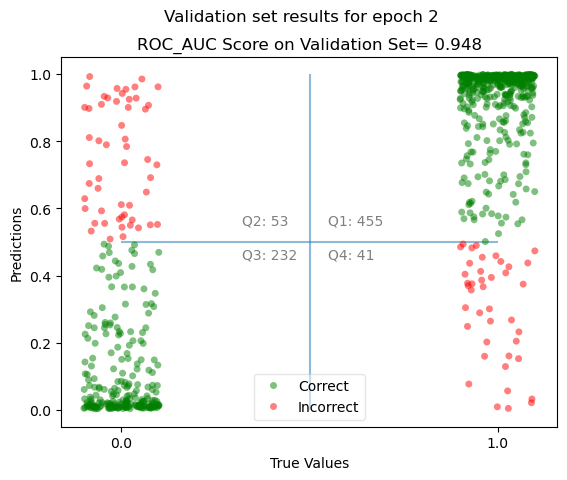

ROC_AUC Score on Test Set       = 0.927
Validation loss improved, saving new model to: chembert/Finetuned_model_2.pt
Epoch time:   0.0 minutes.
Elapsed time: 1.0 minutes out of a maximum of 720.

Epoch 3 of a maximum of 4.


Training  :  41%|███████████▍                | 40/98 [00:13<00:19,  2.96batch/s][19:24:33] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


Training  :  89%|████████████████████████▊   | 87/98 [00:39<00:03,  3.00batch/s][19:24:59] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCC[C@H](OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


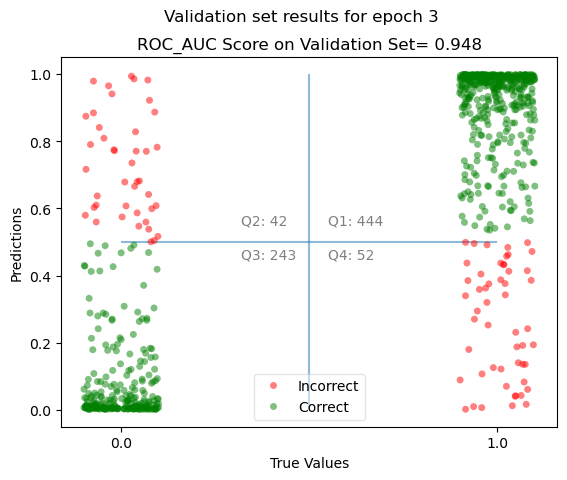

ROC_AUC Score on Test Set       = 0.936
Validation loss improved, saving new model to: chembert/Finetuned_model_3.pt
Epoch time:   0.0 minutes.
Elapsed time: 2.0 minutes out of a maximum of 720.

Epoch 4 of a maximum of 4.


Training  :  52%|██████████████▌             | 51/98 [00:17<00:15,  2.99batch/s][19:25:26] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCC[C@H](OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


Training  :  56%|███████████████▋            | 55/98 [00:18<00:14,  3.00batch/s][19:25:27] Explicit valence for atom # 10 C, 4, is greater than permitted


BAD SMILES: C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1


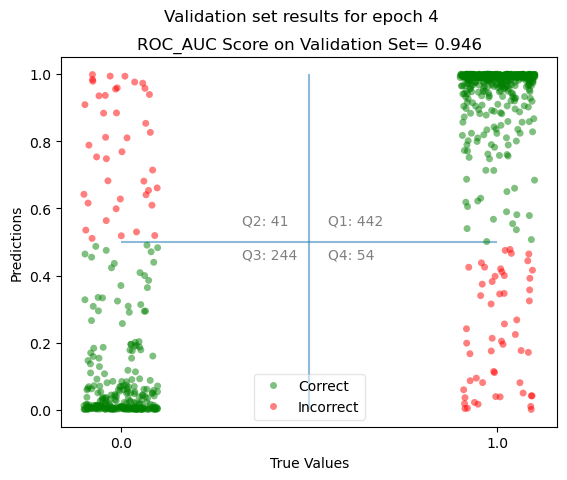

ROC_AUC Score on Test Set       = 0.937
Epoch time:   0.0 minutes.
Elapsed time: 2.0 minutes out of a maximum of 720.
############################################################
            FINISHED FINE-TUNING CHEMBERT MODEL             
############################################################
TOTAL ELAPSED TIME: 2.0 minutes.
The lowest validation loss is from Epoch 3.
which is saved as 'chembert/Finetuned_model_3.pt'.
Score in Testing Set: 0.936361063950198


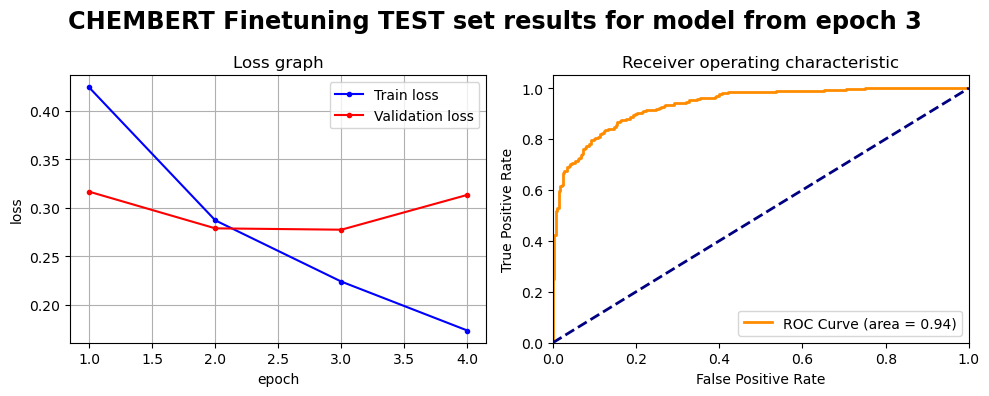


FINAL MODEL:
The best model was saved in file 'chembert/Finetuned_model_final.pt'.


In [23]:
%time
finetune_CHEMBERT.finetune_model(logbb_data, max_epochs=4, task='classification')

Notice that, as CHEM-BERT becomes better in detecting BBB- molecules, it looses some of the sensitivity towards the BBB+ molecules.

### Applying the Model to Random Molecules

Now that we have trained CHEM-BERT, let's generate 1,000 random molecules, and see how they fare with respect to BBB crossing.

In [24]:
%time
smis = generator.generate_smis(1000)
unbiased_mols = [Chem.MolFromSmiles(x) for x in smis]

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


Generated    : 1591
Valid SMILES : 1001 (62.92% of the total)
Unique SMILES: 1000 (62.85% of the total)


To evaluate the BBB crossing, let's load the best CHEM-BERT model we have, which was saved to a file called `chembert/Finetuned_model_final.pt`:

For that, we will create an Estimator object with instructions to use CHEM-BERT:

In [25]:
import Estimators

Let's set the configuration options:

In [26]:
config_opts = {
    'CHEMBERT_predictor':{
        'task':'classification',
        'model_file':'chembert/Finetuned_model_final.pt',
        'optimize':True,
        'threshold':0.4,
        'threshold_step':0.1,
        'threshold_limit':0.95
    }
}

In [27]:
estimator = Estimators.Estimators(config_opts)

--------------------------------------------------------------------------------
Loading Property: CHEMBERT_PREDICTOR
Initializing CHEMBERT model
   Property Name: CHEMBERT_predictor
   task: classification
   model_file: chembert/Finetuned_model_final.pt
   optimize: True
   threshold: 0.4
   threshold_step: 0.1
   threshold_limit: 0.95
  Reward Weight = 1.0
  Reward class = hard
  Initial Threshold = 0.4
  Optimize:  True
    Threshold Limit = 0.95
    Threshold Step = 0.1
CHEMBERT_PREDICTOR loaded as a increasing property
with inital threshold 0.4 and limit 0.95.

When using this, please cite:
   Kim, H., Lee, J., Ahn, S., & Lee, J. R. (2021).
  "A merged molecular representation learning for molecular 
  properties prediction with a web-based service." 
  Scientific Reports, 11(1), 11028.
  https://doi.org/10.1038/s41598-021-90259-7



/blue/lic/seabra/.conda/envs/IntroAIPharma/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/blue/lic/seabra/teaching/IntroAIPharma/workshop/CHEMBERT/chembert.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrar

Done.
Done Loading Property: CHEMBERT_PREDICTOR
--------------------------------------------------------------------------------
Done reading properties.
The maximum possible reward per molecule is:  15.00
Note: Maximum rewards only consider properties being optimized.




OK, we loaded the best trained model. Now, let's use to predict the label for the random molecules.

Remeber, CHEM-BERT generates a number in the $[0,1]$ interval which represents the probability that a molecule is BBB+.

In [28]:
%time
unbiased_results = estimator.estimate_properties(unbiased_mols)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 μs


100%|██████████| 1000/1000 [00:02<00:00, 434.07it/s]


As a "sanity check", let's just check that the size of the arrays are the same (we predicted values for all molecules):

In [29]:
len(smis), len(unbiased_mols), len(unbiased_results['CHEMBERT_predictor'])

(1000, 1000, 1000)

Now, let's look at the results:

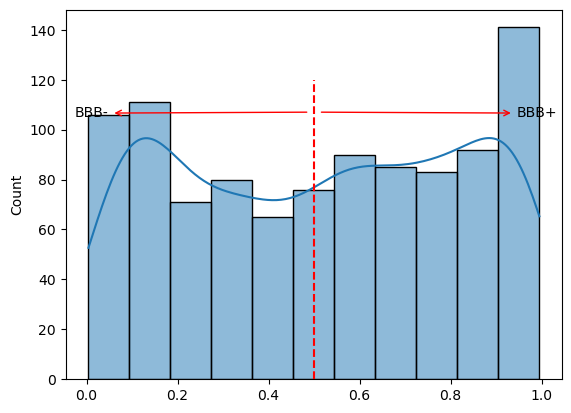

In [30]:
fig, ax = plt.subplots()
ax=sns.histplot(data=unbiased_results['CHEMBERT_predictor'], kde=True)
threshold = 0.5
plt.vlines(threshold,0,120,color='red', ls='--')
plt.annotate('BBB+',(threshold + 0.01,107), (ax.get_xlim()[1] - 0.1,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
plt.annotate('BBB-',(threshold - 0.01,107), (ax.get_xlim()[0] + 0.02,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );

We can classify the labels as BBB+/BBB- with:

Text(0.5, 1.0, 'Unbiased')

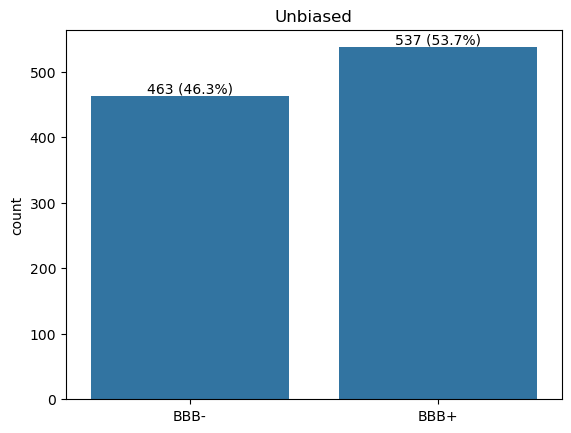

In [31]:
fig, ax = plt.subplots()
unbiased_labels = ["BBB+" if x>=0.5 else "BBB-" for x in unbiased_results['CHEMBERT_predictor']]
sns.countplot(x=unbiased_labels,order=['BBB-','BBB+'], ax=ax)
counts_unbiased=np.array([sum(np.array(unbiased_labels) == "BBB-"),sum(np.array(unbiased_labels) == "BBB+")])
rel_counts_unb = counts_unbiased / len(unbiased_labels)
labels_unb = [f"{l[0]} ({l[1]:0.1%})" for l in zip(counts_unbiased, rel_counts_unb)]
ax.bar_label(container=ax.containers[0], labels=labels_unb)
ax.set_title("Unbiased")

## 3. Generating BBB+ Molecules

### Biasing the Molecular Generator

Let's look at the distribution of the randomly generated molecules:

In [32]:
n_BBB_plus  = sum(np.array(unbiased_labels) == "BBB+")
n_BBB_minus = sum(np.array(unbiased_labels) == "BBB-")
print(f"Number of BBB+ molecules: {n_BBB_plus} ({ n_BBB_plus /(n_BBB_plus + n_BBB_minus):0.1%}) ")
print(f"Number of BBB- molecules: {n_BBB_minus} ({n_BBB_minus/(n_BBB_plus + n_BBB_minus):0.1%}) ")

Number of BBB+ molecules: 537 (53.7%) 
Number of BBB- molecules: 463 (46.3%) 


So, in a set of 1,000 random molecules generated, a bit more than half are able to cross the BBB. Interestingly, this mirrors the distribution of the training set.

**Can we do better?**

Or, can we teach the generator to create more molecules that *can* cross the BBB?

For that, we will use a method called "Reinforcement Learning". We will create a new "Estimator" object that can calculate the properties and rewards for the RL cycle

In [33]:
generator_opts ={
    'verbosity':0
}

In [34]:
%time
generator.bias_generator(estimator, generator_opts)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 6.2 μs


################################################################################
#                              BIASING GENERATOR                               #
################################################################################
# Generator: ReLeaSE                                                           #
# Bucket size: 200                                                             #
# Policy microiterations: 15                                                   #
# Max iterations: 100                                                          #
################################################################################
GENERATING INITIAL BATCH


Generated    : 311
Valid SMILES : 200 (64.31% of the total)
Unique SMILES: 200 (64.31% of the total)


100%|██████████| 200/200 [00:00<00:00, 318.48it/s]



UNBIASED GENERATOR
UNBIASED PROPERTIES
     #  Molecule                           CHEMBERT_predictor
     0  NC(C(=O)O)C(=O)OCC(=O)NCCCC(=O...                0.06
     1  O=C(CCN1C(=O)CNc2ccc(F)cc21)NC...                0.99
     2  Cc1cccc(NC(=O)c2cccc(NC(=O)Cc3...                0.65
     3  CN(CCN1CCCC1)C(=O)CNCC(=O)Nc1n...                0.85
     4  O=C1CC2CNCCN2c2ncncc2N1                          0.91
     5  COc1ccc(Oc2ccc(CN3CCCCC3)cc2CN...                0.88
     6  CCC(C)CNC(=O)C1=CC(=O)N(C)C1=O                   0.94
     7  Oc1ccc2c(NCc3cc4ccccc4nc3-c3cc...                0.29
     8  CC(C)(C)NC(=O)c1ccc(-c2ccc(Cl)...                0.86
     9  COc1ccc(Cc2nc3c(o2)C(=O)OC=CC=...                0.75
    10  Cc1cccc2ccnc(Nc3cccc(Cl)c3)c12                   0.90
    11  C=CCN(O)c1nnn2c1OC(Cc1ccc([N+]...                0.45
    12  O=C(Nc1cccs1)C1CCCN(S(=O)(=O)c...                0.96
    13  CC1CCN(COc2ccc(-c3ccccc3CNCCCN...                0.72
    14  Cc1cc(C=CC(=O)NN2CCCc3



################################################################################
Reinforcement Iteration 1 of 100.
--------------------------------------------------------------------------------


Policy Iteration 1 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.400	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 50.28it/s]


  Average rewards =     9.40
  Average loss    =   170.37




Generated    : 331
Valid SMILES : 200 (60.42% of the total)
Unique SMILES: 200 (60.42% of the total)


100%|██████████| 200/200 [00:00<00:00, 350.15it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.55
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                     10.03   10.03
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.70    6.70
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 20
Valid SMILES : 10 (50.00% of the total)
Unique SMILES: 10 (50.00% of the total)


100%|██████████| 10/10 [00:00<00:00, 54.53it/s]


  Average rewards =     3.80
  Average loss    =    75.90




Generated    : 305
Valid SMILES : 200 (65.57% of the total)
Unique SMILES: 200 (65.57% of the total)


100%|██████████| 200/200 [00:00<00:00, 318.90it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.49
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.22    4.22
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.89    5.89
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 55.74it/s]


  Average rewards =     3.80
  Average loss    =    75.59




Generated    : 322
Valid SMILES : 200 (62.11% of the total)
Unique SMILES: 200 (62.11% of the total)


100%|██████████| 200/200 [00:00<00:00, 331.80it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.55
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.57    4.57
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.10    6.10
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 426/426 [00:00<00:00, 430.11it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 4 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.784	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.53it/s]


  Average rewards =     2.40
  Average loss    =    49.09




Generated    : 304
Valid SMILES : 200 (65.79% of the total)
Unique SMILES: 200 (65.79% of the total)


100%|██████████| 200/200 [00:00<00:00, 330.51it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.60
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.90    5.90
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.68    6.68
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 14
Valid SMILES : 10 (71.43% of the total)
Unique SMILES: 10 (71.43% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.98it/s]


  Average rewards =     2.40
  Average loss    =    44.21




Generated    : 312
Valid SMILES : 200 (64.10% of the total)
Unique SMILES: 200 (64.10% of the total)


100%|██████████| 200/200 [00:00<00:00, 331.88it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.54
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      3.73    3.73
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.55    5.55
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 14
Valid SMILES : 10 (71.43% of the total)
Unique SMILES: 10 (71.43% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.80it/s]


  Average rewards =     3.80
  Average loss    =    59.51




Generated    : 310
Valid SMILES : 200 (64.52% of the total)
Unique SMILES: 200 (64.52% of the total)


100%|██████████| 200/200 [00:00<00:00, 328.76it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.55
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.08    4.08
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.80    5.80
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.21it/s]


  Average rewards =     6.60
  Average loss    =   113.94




Generated    : 324
Valid SMILES : 200 (61.73% of the total)
Unique SMILES: 200 (61.73% of the total)


100%|██████████| 200/200 [00:00<00:00, 311.39it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.55
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      3.80    3.80
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.60    5.60
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 43.74it/s]


  Average rewards =     3.80
  Average loss    =    64.14




Generated    : 315
Valid SMILES : 200 (63.49% of the total)
Unique SMILES: 200 (63.49% of the total)


100%|██████████| 200/200 [00:00<00:00, 316.94it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.57
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 448/448 [00:01<00:00, 426.26it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 9 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.833	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 18
Valid SMILES : 10 (55.56% of the total)
Unique SMILES: 10 (55.56% of the total)


100%|██████████| 10/10 [00:00<00:00, 52.06it/s]


  Average rewards =     2.40
  Average loss    =    47.55




Generated    : 307
Valid SMILES : 200 (65.15% of the total)
Unique SMILES: 200 (65.15% of the total)


100%|██████████| 200/200 [00:00<00:00, 328.61it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.60
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.92    4.92
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.29    6.29
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.77it/s]


  Average rewards =     2.40
  Average loss    =    52.47




Generated    : 288
Valid SMILES : 200 (69.44% of the total)
Unique SMILES: 200 (69.44% of the total)


100%|██████████| 200/200 [00:00<00:00, 317.84it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.60
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.06    5.06
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.35    6.35
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 17
Valid SMILES : 10 (58.82% of the total)
Unique SMILES: 10 (58.82% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.49it/s]


  Average rewards =     2.40
  Average loss    =    44.93




Generated    : 316
Valid SMILES : 200 (63.29% of the total)
Unique SMILES: 200 (63.29% of the total)


100%|██████████| 200/200 [00:00<00:00, 338.72it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.57
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.06    5.06
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.35    6.35
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


  Average rewards =     5.20
  Average loss    =    93.55




Generated    : 305
Valid SMILES : 200 (65.57% of the total)
Unique SMILES: 200 (65.57% of the total)


100%|██████████| 200/200 [00:00<00:00, 321.16it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.60
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.99    4.99
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.32    6.32
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 429/429 [00:00<00:00, 429.90it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 13 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.833	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 46.37it/s]


  Average rewards =     6.60
  Average loss    =    99.85




Generated    : 313
Valid SMILES : 200 (63.90% of the total)
Unique SMILES: 200 (63.90% of the total)


100%|██████████| 200/200 [00:00<00:00, 326.95it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.64
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.28
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.48    5.48
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.53    6.53
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.69it/s]


  Average rewards =     5.20
  Average loss    =    98.86




Generated    : 296
Valid SMILES : 200 (67.57% of the total)
Unique SMILES: 200 (67.57% of the total)


100%|██████████| 200/200 [00:00<00:00, 325.54it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.64
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.76    5.76
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.63    6.63
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 17
Valid SMILES : 10 (58.82% of the total)
Unique SMILES: 10 (58.82% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.61it/s]


  Average rewards =     2.40
  Average loss    =    38.69




Generated    : 301
Valid SMILES : 200 (66.45% of the total)
Unique SMILES: 200 (66.45% of the total)


100%|██████████| 200/200 [00:00<00:00, 311.13it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.61
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.15    4.15
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.85    5.85
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Generated    : 315
Valid SMILES : 200 (63.49% of the total)
Unique SMILES: 200 (63.49% of the total)


100%|██████████| 200/200 [00:00<00:00, 331.75it/s]


FINISHED REINFORCEMENT ITERATION 1
-------------------------------------------------------
|--> Elapsed time (this iteration) = 225.515 sec.
|--> Average time (all iterations) = 225.515 sec./it


################################################################################
Reinforcement Iteration 2 of 100.
--------------------------------------------------------------------------------


Policy Iteration 1 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.902	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 12
Valid SMILES : 10 (83.33% of the total)
Unique SMILES: 10 (83.33% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.20it/s]


  Average rewards =     9.40
  Average loss    =   168.86




Generated    : 316
Valid SMILES : 200 (63.29% of the total)
Unique SMILES: 200 (63.29% of the total)


100%|██████████| 200/200 [00:00<00:00, 331.36it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.62
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.50    4.50
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.06    6.06
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 427/427 [00:01<00:00, 423.84it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 2 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.902	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 13
Valid SMILES : 10 (76.92% of the total)
Unique SMILES: 10 (76.92% of the total)


100%|██████████| 10/10 [00:00<00:00, 46.78it/s]


  Average rewards =     3.80
  Average loss    =    64.20




Generated    : 309
Valid SMILES : 200 (64.72% of the total)
Unique SMILES: 200 (64.72% of the total)


100%|██████████| 200/200 [00:00<00:00, 323.05it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.69
        MINIMUM:                                                                       0.05
        STD DEV:                                                                       0.27
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 18
Valid SMILES : 10 (55.56% of the total)
Unique SMILES: 10 (55.56% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.27it/s]


  Average rewards =     3.80
  Average loss    =    62.85




Generated    : 318
Valid SMILES : 200 (62.89% of the total)
Unique SMILES: 200 (62.89% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.01it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.66
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 43.75it/s]


  Average rewards =     5.20
  Average loss    =   113.72




Generated    : 303
Valid SMILES : 200 (66.01% of the total)
Unique SMILES: 200 (66.01% of the total)


100%|██████████| 200/200 [00:00<00:00, 326.96it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.67
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.26
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.64    4.64
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.14    6.14
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.21it/s]


  Average rewards =     2.40
  Average loss    =    64.66




Generated    : 312
Valid SMILES : 200 (64.10% of the total)
Unique SMILES: 200 (64.10% of the total)


100%|██████████| 200/200 [00:00<00:00, 327.20it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.69
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.28
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.13    5.13
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.38    6.38
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 421/421 [00:01<00:00, 420.97it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 6 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.902	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.67it/s]


  Average rewards =     6.60
  Average loss    =    97.18




Generated    : 305
Valid SMILES : 200 (65.57% of the total)
Unique SMILES: 200 (65.57% of the total)


100%|██████████| 200/200 [00:00<00:00, 323.42it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.68
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.48    5.48
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.53    6.53
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 12
Valid SMILES : 10 (83.33% of the total)
Unique SMILES: 10 (83.33% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.14it/s]


  Average rewards =     5.20
  Average loss    =    75.90




Generated    : 304
Valid SMILES : 200 (65.79% of the total)
Unique SMILES: 200 (65.79% of the total)


100%|██████████| 200/200 [00:00<00:00, 327.72it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.69
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.27
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.64    4.64
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.14    6.14
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 46.45it/s]


  Average rewards =     5.20
  Average loss    =    80.68




Generated    : 307
Valid SMILES : 200 (65.15% of the total)
Unique SMILES: 200 (65.15% of the total)


100%|██████████| 200/200 [00:00<00:00, 323.04it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.68
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 13
Valid SMILES : 10 (76.92% of the total)
Unique SMILES: 10 (76.92% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.78it/s]


  Average rewards =     2.40
  Average loss    =    49.47




Generated    : 312
Valid SMILES : 200 (64.10% of the total)
Unique SMILES: 200 (64.10% of the total)


100%|██████████| 200/200 [00:00<00:00, 315.60it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.67
        MINIMUM:                                                                       0.04
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.20    5.20
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.42    6.42
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 431/431 [00:01<00:00, 422.88it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 10 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.914	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 15
Valid SMILES : 10 (66.67% of the total)
Unique SMILES: 10 (66.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.79it/s]


  Average rewards =     8.00
  Average loss    =   130.96




Generated    : 300
Valid SMILES : 200 (66.67% of the total)
Unique SMILES: 200 (66.67% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.10it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.70
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.28
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 12
Valid SMILES : 10 (83.33% of the total)
Unique SMILES: 10 (83.33% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


  Average rewards =     9.40
  Average loss    =   139.78




Generated    : 294
Valid SMILES : 200 (68.03% of the total)
Unique SMILES: 200 (68.03% of the total)


100%|██████████| 200/200 [00:00<00:00, 320.31it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.75
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.26
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.83    5.83
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.66    6.66
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 12
Valid SMILES : 10 (83.33% of the total)
Unique SMILES: 10 (83.33% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.53it/s]


  Average rewards =     2.40
  Average loss    =    42.28




Generated    : 282
Valid SMILES : 200 (70.92% of the total)
Unique SMILES: 200 (70.92% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.10it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.75
        MINIMUM:                                                                       0.04
        STD DEV:                                                                       0.27
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      6.18    6.18
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.76    6.76
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 14
Valid SMILES : 10 (71.43% of the total)
Unique SMILES: 10 (71.43% of the total)


100%|██████████| 10/10 [00:00<00:00, 50.78it/s]


  Average rewards =     6.60
  Average loss    =    94.16




Generated    : 294
Valid SMILES : 200 (68.03% of the total)
Unique SMILES: 200 (68.03% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.49it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.72
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.28
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.27    5.27
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.45    6.45
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 459/459 [00:01<00:00, 438.53it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0


CHEMBERT_PREDICTOR       :  Threshold adjusted to   0.95


Policy Iteration 14 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.947	   0.950	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 13
Valid SMILES : 10 (76.92% of the total)
Unique SMILES: 10 (76.92% of the total)


100%|██████████| 10/10 [00:00<00:00, 46.42it/s]


  Average rewards =     8.00
  Average loss    =   106.10




Generated    : 295
Valid SMILES : 200 (67.80% of the total)
Unique SMILES: 200 (67.80% of the total)


100%|██████████| 200/200 [00:00<00:00, 328.06it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.77
        MINIMUM:                                                                       0.03
        STD DEV:                                                                       0.26
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.97    5.97
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.70    6.70
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Generated    : 278
Valid SMILES : 200 (71.94% of the total)
Unique SMILES: 200 (71.94% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.76it/s]



FINISHED REINFORCEMENT ITERATION 2
-------------------------------------------------------
|--> Elapsed time (this iteration) = 201.162 sec.
|--> Average time (all iterations) = 213.338 sec./it

-------------- Checkpoint --------------
   Reinforcement Iteration 2:
   Saving generator to file ./chk/biased_generator_002.chk
   and generated SMILES to  ./chk/generated_smiles_002.smi.
-----------------------------------------


All properties converged. Stopping.


############################################################
 FINISHED REINFORCED LEARNING CYCLE
TOTAL: 1 iterations
############################################################
Generating final batch of 200 molecules.


Generated    : 287
Valid SMILES : 200 (69.69% of the total)
Unique SMILES: 200 (69.69% of the total)


100%|██████████| 200/200 [00:00<00:00, 316.95it/s]


Final batch of molecules saved to file ./chk/generated_smiles_final.smi.
Final generator state saved to file ./chk/biased_generator_final.chk.

FINISHED BIASING GENERATOR
|--> Total number of iterations    = 1
-------------------------------------------------------
PROPERTIES
     #  Molecule                           CHEMBERT_predictor
     0  NCCOCCN1CCN(c2ccc(OCC3CCCN3C(=...                0.97
     1  Fc1ccccc1N1CCN2CCC(Cc3ccc(Cl)c...                0.99
     2  CC(C)N(Cc1ccccc1)Cc1ccc(CNC(=O...                0.40
     3  COc1ccc(N2CCC(C(=O)N3CCN(Cc4cc...                0.82
     4  CCN(CC)c1ccc(NC2CCCO2)cc1                        0.84
     5  CN(c1ccc(F)cc1)C1CCN(Cc2ccc(C#...                0.99
     6  COC(=O)C1CCCN(Cc2ccco2)C1                        0.97
     7  CN(CC(=O)N1CCN(CCc2ccccc2)CC1)...                0.98
     8  CN(c1ccccc1)S(=O)(=O)F                           0.86
     9  O=C(NC1CCCCC1)N1CCC(C(c2ccccc2...                0.98
    10  CN(Cc1ccc(Sc2cccc(C(F)(F)F)c2)...

### Generating New Molecules

OK, the biasing worked, and now we can use this generator to create new molecules. The new generator state was saved in the `chk` folder, under the name `biased_generator_final.chk`:

In [35]:
!ls chk

biased_generator_final.chk  generated_smiles_final.smi	unbiased.smi


Let's load this new generator:

In [36]:
%time
generator_properties = {
    'name':'ReLeaSE',    # Just a name to remeber what generator we are using
    'batch_size':200,    # Generate this many molecules at a time, unless we specify the desired number
    'initial_state':'chk/biased_generator_final.chk'
}
generator = ReLeaSE.ReLeaSE(generator_properties)

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 3.81 μs
Initializing the generator. Please wait a minute...
--> data_path =  release/data/chembl_22_clean_1576904_sorted_std_final.smi
--> tokens    =  ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']', '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
Generator ready to be used. Elapsed time: 20.54 seconds.

Loading generator from file chk/biased_generator_final.chk ... Done.


/blue/lic/seabra/teaching/IntroAIPharma/workshop/release/stackRNN.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(path)


Now, we can finally use this new generator to create new molecules:

In [37]:
%time
biased_smis = generator.generate_smis(1000)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 3.81 μs


Generated    : 1490
Valid SMILES : 1001 (67.18% of the total)
Unique SMILES: 1000 (67.11% of the total)


In [38]:
%time
biased_mols = [Chem.MolFromSmiles(x) for x in biased_smis]
biased_results = estimator.estimate_properties(biased_mols)

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 3.81 μs


100%|██████████| 1000/1000 [00:02<00:00, 456.15it/s]


### Compare the results to the unbiased set

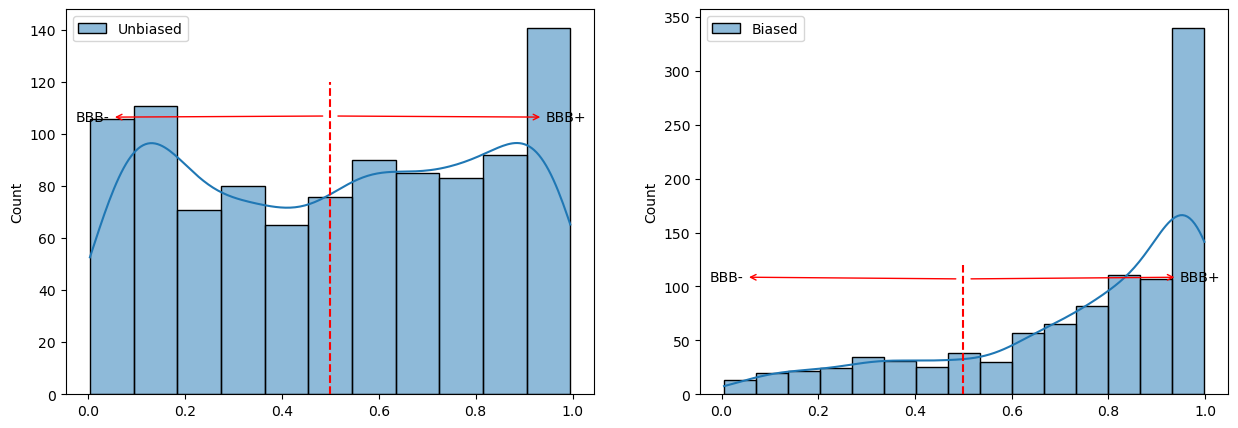

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
threshold = 0.5

sns.histplot(data=unbiased_results, kde=True, ax=ax[0], label='Unbiased')
ax[0].vlines(threshold,0,120,color='red', ls='--')
ax[0].annotate('BBB+',(threshold + 0.01,107), (ax[0].get_xlim()[1] - 0.1,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
ax[0].annotate('BBB-',(threshold - 0.01,107), (ax[0].get_xlim()[0] + 0.02,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );
ax[0].legend()

sns.histplot(data=biased_results, kde=True, ax=ax[1], label='Biased')
ax[1].vlines(threshold,0,120,color='red', ls='--')
ax[1].annotate('BBB+',(threshold + 0.01,107), (ax[1].get_xlim()[1] - 0.1,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
ax[1].annotate('BBB-',(threshold - 0.01,107), (ax[1].get_xlim()[0] + 0.02,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );
ax[1].legend();

We can classify the labels as BBB+/BBB- with:

In [40]:
biased_labels = ["BBB+" if x>=0.5 else "BBB-" for x in biased_results['CHEMBERT_predictor']]

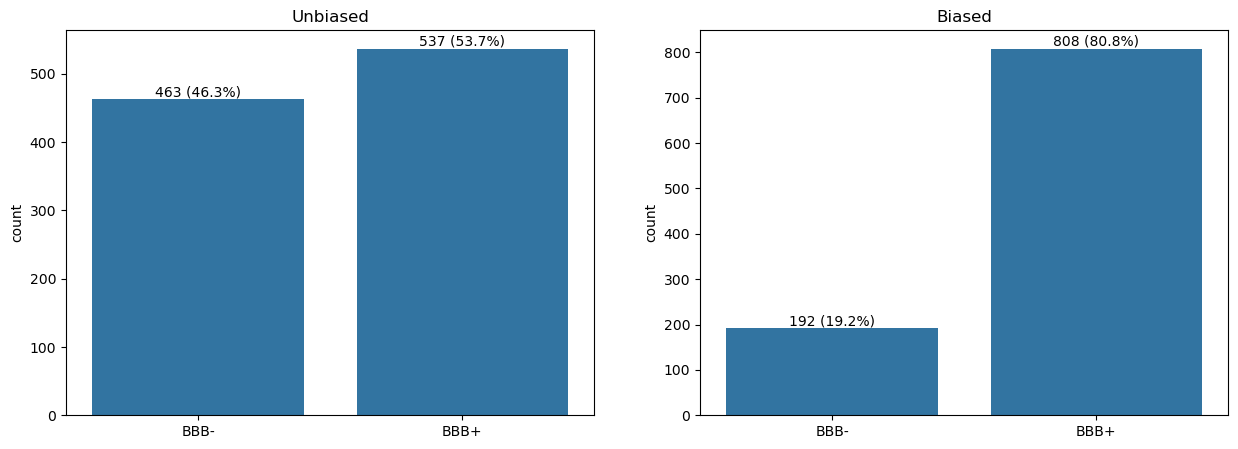

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

# Unbiased set
sns.countplot(x=unbiased_labels,order=['BBB-','BBB+'], ax=ax[0])
counts_unbiased=np.array([sum(np.array(unbiased_labels) == "BBB-"),sum(np.array(unbiased_labels) == "BBB+")])
rel_counts_unb = counts_unbiased / len(unbiased_labels)
labels_unb = [f"{l[0]} ({l[1]:0.1%})" for l in zip(counts_unbiased, rel_counts_unb)]

ax[0].bar_label(container=ax[0].containers[0], labels=labels_unb)
ax[0].set_title("Unbiased")
    
# Biased set
sns.countplot(x=biased_labels  ,order=['BBB-','BBB+'], ax=ax[1])
counts_biased=np.array([sum(np.array(biased_labels) == "BBB-"),sum(np.array(biased_labels) == "BBB+")])
rel_counts_bia = counts_biased / len(biased_labels)
labels_bia = [f"{l[0]} ({l[1]:0.1%})" for l in zip(counts_biased, rel_counts_bia)]
ax[1].bar_label(container=ax[1].containers[0], labels=labels_bia)
ax[1].set_title("Biased");



Here's a random sample of the molecules generated by the generator **_before_** biasing

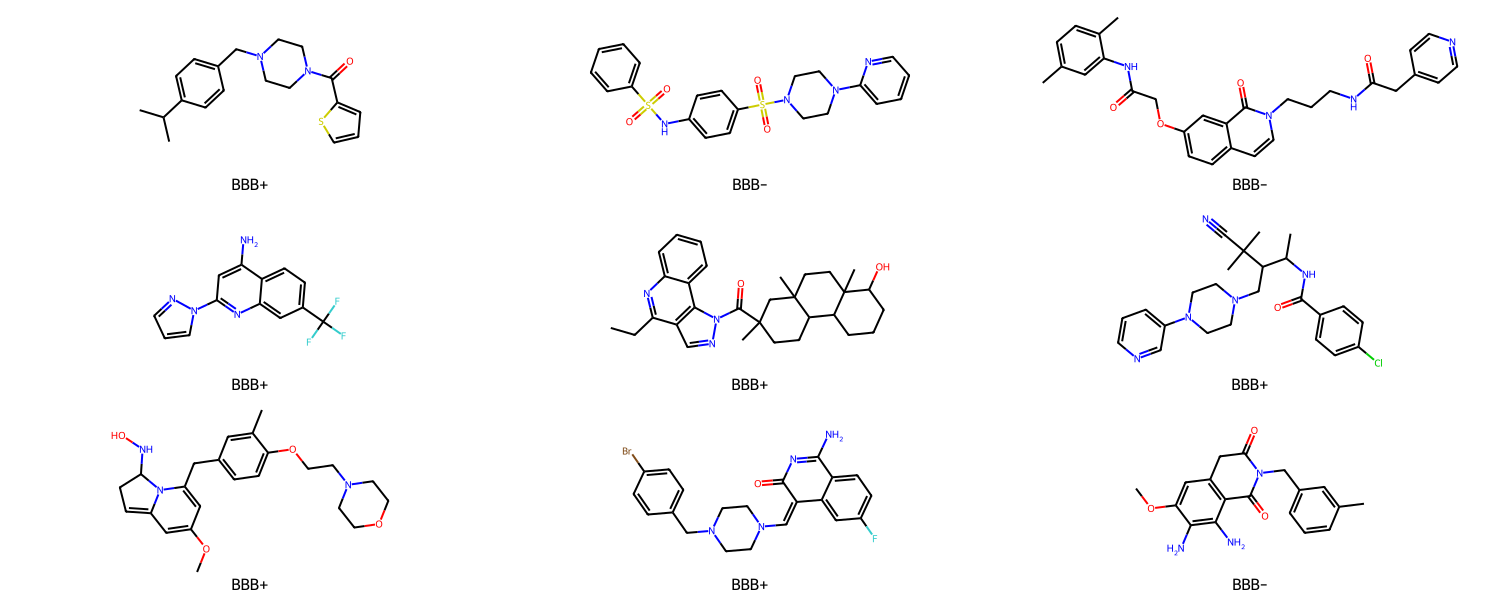

In [42]:
mols_idx =random.sample(range(len(unbiased_mols)), 9)
mols = [unbiased_mols[x] for x in mols_idx]
legends = [unbiased_labels[x] for x in mols_idx]
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200), legends=legends)

And here is a random sample of molecules generated **_after_** the biasing procedure:

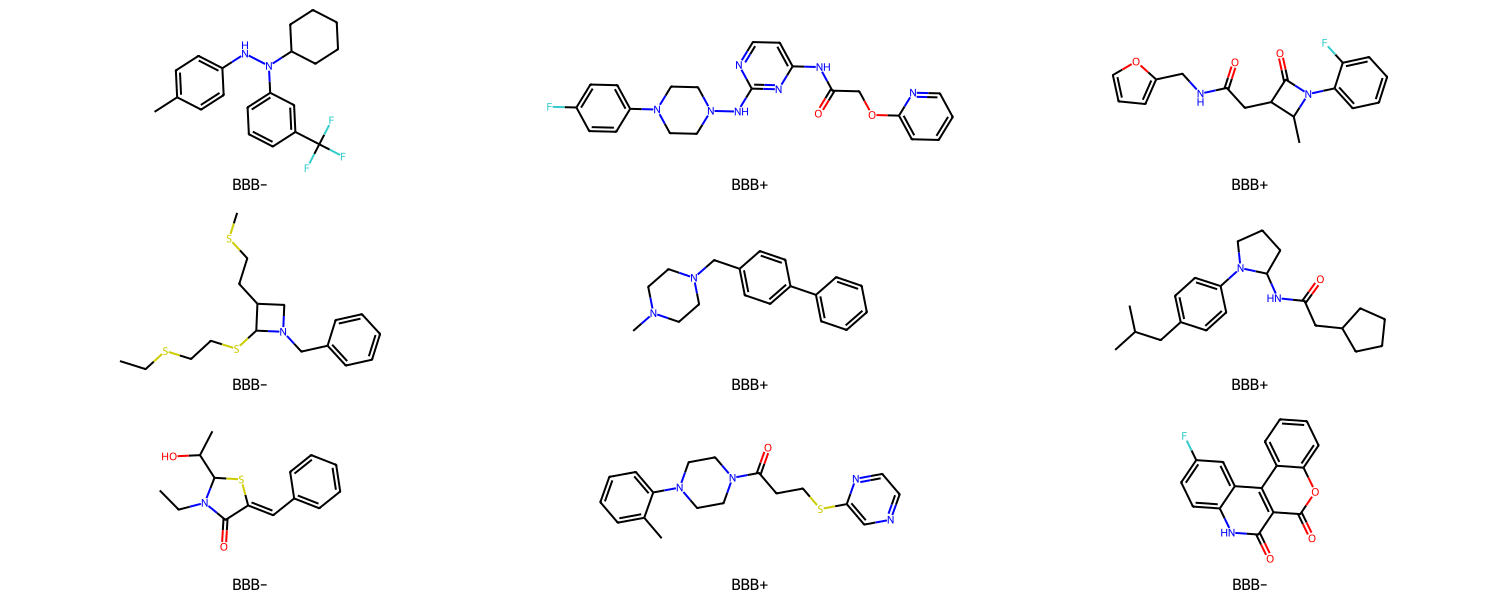

In [43]:
mols_idx =random.sample(range(len(biased_mols)), 9)
mols = [biased_mols[x] for x in mols_idx]
legends = [biased_labels[x] for x in mols_idx]
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200), legends=legends)

## 4. Homework: Generating BBB- Molecules

Now, imagine you want molecules that **don't** cross the BBB. Can we bias the generator for that task?

### Biasing a new generator

We will start with a new, unbiased generator.

In [44]:
%time
generator_properties = {
    'name':'ReLeaSE',    # Just a name to remeber what generator we are using
    'batch_size':200,    # Generate this many molecules at a time, unless we specify the desired number
    'initial_state':'release/checkpoints/generator/checkpoint_biggest_rnn' # The unbiased state of the generator
}
generator = ReLeaSE.ReLeaSE(generator_properties)

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 5.48 μs
Initializing the generator. Please wait a minute...
--> data_path =  release/data/chembl_22_clean_1576904_sorted_std_final.smi
--> tokens    =  ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']', '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
Generator ready to be used. Elapsed time: 19.70 seconds.

Loading generator from file release/checkpoints/generator/checkpoint_biggest_rnn ... 

/blue/lic/seabra/teaching/IntroAIPharma/workshop/release/stackRNN.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(path)


Done.


Let's change the optimization to *decrease* the probability that generated molecules can cross the BBB. Now we want to move the generator towards a small threshold.

In [45]:
config_opts = {
    'CHEMBERT_predictor':{
        'task':'classification',
        'model_file':'chembert/Finetuned_model_final.pt',
        'optimize':True,
        'threshold':0.5,
        'threshold_step':-0.1,
        'threshold_limit':0.05
    }
}

In [46]:
estimator = Estimators.Estimators(config_opts)

--------------------------------------------------------------------------------
Loading Property: CHEMBERT_PREDICTOR
Initializing CHEMBERT model
   Property Name: CHEMBERT_predictor
   task: classification
   model_file: chembert/Finetuned_model_final.pt
   optimize: True
   threshold: 0.5
   threshold_step: -0.1
   threshold_limit: 0.05
  Reward Weight = 1.0
  Reward class = hard
  Initial Threshold = 0.5
  Optimize:  True
    Threshold Limit = 0.05
    Threshold Step = -0.1
CHEMBERT_PREDICTOR loaded as a decreasing property
with inital threshold 0.5 and limit 0.05.

When using this, please cite:
   Kim, H., Lee, J., Ahn, S., & Lee, J. R. (2021).
  "A merged molecular representation learning for molecular 
  properties prediction with a web-based service." 
  Scientific Reports, 11(1), 11028.
  https://doi.org/10.1038/s41598-021-90259-7

Done.
Done Loading Property: CHEMBERT_PREDICTOR
--------------------------------------------------------------------------------
Done reading proper

/blue/lic/seabra/.conda/envs/IntroAIPharma/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/blue/lic/seabra/teaching/IntroAIPharma/workshop/CHEMBERT/chembert.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrar

In [47]:
generator_opts ={
    'verbosity':0
}

In [48]:
%time
generator.bias_generator(estimator, generator_opts)

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 3.81 μs


################################################################################
#                              BIASING GENERATOR                               #
################################################################################
# Generator: ReLeaSE                                                           #
# Bucket size: 200                                                             #
# Policy microiterations: 15                                                   #
# Max iterations: 100                                                          #
################################################################################
GENERATING INITIAL BATCH


Generated    : 319
Valid SMILES : 200 (62.70% of the total)
Unique SMILES: 200 (62.70% of the total)


100%|██████████| 200/200 [00:00<00:00, 322.17it/s]



UNBIASED GENERATOR
UNBIASED PROPERTIES
     #  Molecule                           CHEMBERT_predictor
     0  Cc1ccc(-c2c[nH]c3ccccc23)c(C)c...                0.86
     1  OCCN(CCNc1nc2c(c3ccc(Cl)cc13)C...                0.90
     2  O=C(CN1c2ccccc2Oc2ccccc21)Nc1c...                1.00
     3  CCCCOc1cc(NC(C)=O)ccc1N1OC=CN=...                0.88
     4  CN(Cc1cccc2ccccc12)C(=O)SCCN                     0.97
     5  Nc1ccccc1Nc1ccncn1                               0.53
     6  COc1cc(S(=O)(=O)N2CCN(c3nc4ccc...                0.59
     7  CC(C)CCCC(CN1CCN(CCO)CC1)C(=O)...                0.07
     8  COc1cccc(-c2nc3ccccn3n2)c1                       0.76
     9  O=C(CF)c1ccc(C(F)(F)F)cc1                        0.58
    10  CN1CCN(S(=O)(=O)c2cc(S(=O)(=O)...                0.63
    11  O=C(CCC1CCc2cc(-c3ccccc3)c(-c3...                0.12
    12  c1ccc(CCn2nc(COc3ccccc3)c3cc4c...                0.87
    13  COC(=O)C(C)C                                     0.95
    14  COc1cc(C)cc(S(=O)(=O)N



################################################################################
Reinforcement Iteration 1 of 100.
--------------------------------------------------------------------------------


Policy Iteration 1 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.500	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 13
Valid SMILES : 10 (76.92% of the total)
Unique SMILES: 10 (76.92% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.65it/s]


  Average rewards =     5.20
  Average loss    =   101.96




Generated    : 334
Valid SMILES : 200 (59.88% of the total)
Unique SMILES: 200 (59.88% of the total)


100%|██████████| 200/200 [00:00<00:00, 339.08it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.53
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      7.44    7.44
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.98    6.98
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.88it/s]


  Average rewards =     5.20
  Average loss    =   125.67




Generated    : 302
Valid SMILES : 200 (66.23% of the total)
Unique SMILES: 200 (66.23% of the total)


100%|██████████| 200/200 [00:00<00:00, 321.52it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.49
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.41    5.41
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.50    6.50
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 18
Valid SMILES : 10 (55.56% of the total)
Unique SMILES: 10 (55.56% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.71it/s]


  Average rewards =     5.20
  Average loss    =   152.22




Generated    : 343
Valid SMILES : 200 (58.31% of the total)
Unique SMILES: 200 (58.31% of the total)


100%|██████████| 200/200 [00:00<00:00, 322.72it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.52
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.36    4.36
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.98    5.98
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 403/403 [00:01<00:00, 376.91it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 4 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.262	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 21
Valid SMILES : 10 (47.62% of the total)
Unique SMILES: 10 (47.62% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.21it/s]


  Average rewards =     3.80
  Average loss    =    74.86




Generated    : 310
Valid SMILES : 200 (64.52% of the total)
Unique SMILES: 200 (64.52% of the total)


100%|██████████| 200/200 [00:00<00:00, 310.59it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.50
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.33
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.62    5.62
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.58    6.58
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 12
Valid SMILES : 10 (83.33% of the total)
Unique SMILES: 10 (83.33% of the total)


100%|██████████| 10/10 [00:00<00:00, 53.24it/s]


  Average rewards =     3.80
  Average loss    =    69.08




Generated    : 347
Valid SMILES : 200 (57.64% of the total)
Unique SMILES: 200 (57.64% of the total)


100%|██████████| 200/200 [00:00<00:00, 326.62it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.50
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.28
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      3.45    3.45
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.32    5.32
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 24
Valid SMILES : 10 (41.67% of the total)
Unique SMILES: 10 (41.67% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.48it/s]


  Average rewards =     2.40
  Average loss    =    66.65




Generated    : 316
Valid SMILES : 200 (63.29% of the total)
Unique SMILES: 200 (63.29% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.00it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.47
        MINIMUM:                                                                       0.02
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.57    4.57
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.10    6.10
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 14
Valid SMILES : 10 (71.43% of the total)
Unique SMILES: 10 (71.43% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.74it/s]


  Average rewards =     6.60
  Average loss    =   171.02




Generated    : 336
Valid SMILES : 200 (59.52% of the total)
Unique SMILES: 200 (59.52% of the total)


100%|██████████| 200/200 [00:00<00:00, 328.23it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.50
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.71    4.71
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.18    6.18
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 405/405 [00:00<00:00, 423.27it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 8 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.218	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 20
Valid SMILES : 10 (50.00% of the total)
Unique SMILES: 10 (50.00% of the total)


100%|██████████| 10/10 [00:00<00:00, 52.32it/s]


  Average rewards =     5.20
  Average loss    =   123.91




Generated    : 345
Valid SMILES : 200 (57.97% of the total)
Unique SMILES: 200 (57.97% of the total)


100%|██████████| 200/200 [00:00<00:00, 343.64it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.43
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.97    5.97
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.70    6.70
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 17
Valid SMILES : 10 (58.82% of the total)
Unique SMILES: 10 (58.82% of the total)


100%|██████████| 10/10 [00:00<00:00, 45.14it/s]


  Average rewards =     5.20
  Average loss    =   145.08




Generated    : 340
Valid SMILES : 200 (58.82% of the total)
Unique SMILES: 200 (58.82% of the total)


100%|██████████| 200/200 [00:00<00:00, 330.36it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.42
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 17
Valid SMILES : 10 (58.82% of the total)
Unique SMILES: 10 (58.82% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.97it/s]


  Average rewards =     3.80
  Average loss    =    70.84




Generated    : 357
Valid SMILES : 200 (56.02% of the total)
Unique SMILES: 200 (56.02% of the total)


100%|██████████| 200/200 [00:00<00:00, 311.25it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.42
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.85    4.85
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.25    6.25
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 23
Valid SMILES : 10 (43.48% of the total)
Unique SMILES: 10 (43.48% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.95it/s]


  Average rewards =     3.80
  Average loss    =    84.89




Generated    : 348
Valid SMILES : 200 (57.47% of the total)
Unique SMILES: 200 (57.47% of the total)


100%|██████████| 200/200 [00:00<00:00, 326.41it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.41
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.64    4.64
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.14    6.14
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 433/433 [00:01<00:00, 343.80it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 12 of 15.
(RL Iteration 1 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.160	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 23
Valid SMILES : 10 (43.48% of the total)
Unique SMILES: 10 (43.48% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.19it/s]


  Average rewards =     6.60
  Average loss    =   185.55




Generated    : 361
Valid SMILES : 200 (55.40% of the total)
Unique SMILES: 200 (55.40% of the total)


100%|██████████| 200/200 [00:00<00:00, 325.81it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.43
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.06    5.06
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.35    6.35
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 26
Valid SMILES : 10 (38.46% of the total)
Unique SMILES: 10 (38.46% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.82it/s]


  Average rewards =     8.00
  Average loss    =   145.85




Generated    : 332
Valid SMILES : 200 (60.24% of the total)
Unique SMILES: 200 (60.24% of the total)


100%|██████████| 200/200 [00:00<00:00, 325.30it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.98
        AVERAGES:                                                                      0.39
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.41    5.41
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.50    6.50
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 22
Valid SMILES : 10 (45.45% of the total)
Unique SMILES: 10 (45.45% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.18it/s]


  Average rewards =     8.00
  Average loss    =   154.98




Generated    : 360
Valid SMILES : 200 (55.56% of the total)
Unique SMILES: 200 (55.56% of the total)


100%|██████████| 200/200 [00:00<00:00, 315.30it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.45
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.50    4.50
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.06    6.06
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.31it/s]


  Average rewards =     8.00
  Average loss    =   223.67




Generated    : 348
Valid SMILES : 200 (57.47% of the total)
Unique SMILES: 200 (57.47% of the total)


100%|██████████| 200/200 [00:00<00:00, 320.90it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.41
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.06    5.06
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.35    6.35
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 429/429 [00:01<00:00, 421.15it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0


Generated    : 412
Valid SMILES : 200 (48.54% of the total)
Unique SMILES: 200 (48.54% of the total)


100%|██████████| 200/200 [00:00<00:00, 317.07it/s]


FINISHED REINFORCEMENT ITERATION 1
-------------------------------------------------------
|--> Elapsed time (this iteration) = 293.829 sec.
|--> Average time (all iterations) = 293.829 sec./it


################################################################################
Reinforcement Iteration 2 of 100.
--------------------------------------------------------------------------------


Policy Iteration 1 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.156	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 20
Valid SMILES : 10 (50.00% of the total)
Unique SMILES: 10 (50.00% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.21it/s]


  Average rewards =     6.60
  Average loss    =   150.04




Generated    : 357
Valid SMILES : 200 (56.02% of the total)
Unique SMILES: 200 (56.02% of the total)


100%|██████████| 200/200 [00:00<00:00, 322.07it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.37
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.69    5.69
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.61    6.61
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.28it/s]


  Average rewards =     3.80
  Average loss    =    78.95




Generated    : 358
Valid SMILES : 200 (55.87% of the total)
Unique SMILES: 200 (55.87% of the total)


100%|██████████| 200/200 [00:00<00:00, 323.55it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.38
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.32
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.41    5.41
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.50    6.50
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 29
Valid SMILES : 10 (34.48% of the total)
Unique SMILES: 10 (34.48% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.57it/s]


  Average rewards =     9.40
  Average loss    =   233.48




Generated    : 366
Valid SMILES : 200 (54.64% of the total)
Unique SMILES: 200 (54.64% of the total)


100%|██████████| 200/200 [00:00<00:00, 309.40it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.97
        AVERAGES:                                                                      0.38
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.20    5.20
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.42    6.42
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 52.93it/s]


  Average rewards =     8.00
  Average loss    =   171.11




Generated    : 334
Valid SMILES : 200 (59.88% of the total)
Unique SMILES: 200 (59.88% of the total)


100%|██████████| 200/200 [00:00<00:00, 328.99it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.98
        AVERAGES:                                                                      0.33
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.62    5.62
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.58    6.58
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 456/456 [00:01<00:00, 433.97it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0


CHEMBERT_PREDICTOR       :  Threshold adjusted to   0.10


Policy Iteration 5 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.101	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 46.40it/s]


  Average rewards =     5.20
  Average loss    =   118.68




Generated    : 375
Valid SMILES : 200 (53.33% of the total)
Unique SMILES: 200 (53.33% of the total)


100%|██████████| 200/200 [00:00<00:00, 329.29it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.33
        MINIMUM:                                                                       0.01
        STD DEV:                                                                       0.30
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      6.04    6.04
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.72    6.72
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 18
Valid SMILES : 10 (55.56% of the total)
Unique SMILES: 10 (55.56% of the total)


100%|██████████| 10/10 [00:00<00:00, 48.45it/s]


  Average rewards =     2.40
  Average loss    =    65.24




Generated    : 345
Valid SMILES : 200 (57.97% of the total)
Unique SMILES: 200 (57.97% of the total)


100%|██████████| 200/200 [00:00<00:00, 333.90it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.33
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.92    4.92
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.29    6.29
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 18
Valid SMILES : 10 (55.56% of the total)
Unique SMILES: 10 (55.56% of the total)


100%|██████████| 10/10 [00:00<00:00, 49.69it/s]


  Average rewards =     3.80
  Average loss    =    87.98




Generated    : 335
Valid SMILES : 200 (59.70% of the total)
Unique SMILES: 200 (59.70% of the total)


100%|██████████| 200/200 [00:00<00:00, 335.68it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.32
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.20    5.20
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.42    6.42
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 22
Valid SMILES : 10 (45.45% of the total)
Unique SMILES: 10 (45.45% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.05it/s]


  Average rewards =     5.20
  Average loss    =   110.97




Generated    : 360
Valid SMILES : 200 (55.56% of the total)
Unique SMILES: 200 (55.56% of the total)


100%|██████████| 200/200 [00:00<00:00, 318.27it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       1.00
        AVERAGES:                                                                      0.34
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.31
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.43    4.43
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.02    6.02
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

100%|██████████| 437/437 [00:01<00:00, 417.66it/s]


   --> LENGTH OF gen_data.file = 200
   --> Average rewards for the new gen_data: 15.0




Policy Iteration 9 of 15.
(RL Iteration 2 of 100)
--------------------------------------------------------------------------------
Property                           Threshold	   Limit	Converged?
    ---> CHEMBERT_predictor       :    0.075	   0.050	     False
--------------------------------------------------------------------------------


Training generator with gen_data


Generated    : 11
Valid SMILES : 10 (90.91% of the total)
Unique SMILES: 10 (90.91% of the total)


100%|██████████| 10/10 [00:00<00:00, 53.53it/s]


  Average rewards =     5.20
  Average loss    =   124.37




Generated    : 411
Valid SMILES : 200 (48.66% of the total)
Unique SMILES: 200 (48.66% of the total)


100%|██████████| 200/200 [00:00<00:00, 344.70it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.98
        AVERAGES:                                                                      0.29
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      6.04    6.04
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.72    6.72
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 19
Valid SMILES : 10 (52.63% of the total)
Unique SMILES: 10 (52.63% of the total)


100%|██████████| 10/10 [00:00<00:00, 47.41it/s]


  Average rewards =     6.60
  Average loss    =   151.40




Generated    : 374
Valid SMILES : 200 (53.48% of the total)
Unique SMILES: 200 (53.48% of the total)


100%|██████████| 200/200 [00:00<00:00, 326.51it/s]

     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.98
        AVERAGES:                                                                      0.32
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      4.01    4.01
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       5.75    5.75
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Training generator with gen_data


Generated    : 16
Valid SMILES : 10 (62.50% of the total)
Unique SMILES: 10 (62.50% of the total)


100%|██████████| 10/10 [00:00<00:00, 44.77it/s]


  Average rewards =     3.80
  Average loss    =    86.14




Generated    : 350
Valid SMILES : 200 (57.14% of the total)
Unique SMILES: 200 (57.14% of the total)


100%|██████████| 200/200 [00:00<00:00, 331.07it/s]


     #  PROPERTIES                                                       CHEMBERT_predictor
        MAXIMUM:                                                                       0.99
        AVERAGES:                                                                      0.27
        MINIMUM:                                                                       0.00
        STD DEV:                                                                       0.29
     #  REWARDS                                                          CHEMBERT_predictor   TOTAL
        MAXIMUM:                                                                      15.00   15.00
        AVERAGES:                                                                      5.55    5.55
        MINIMUM:                                                                       1.00    1.00
        STD DEV:                                                                       6.56    6.56
 NUMBER OF MOLECULES   : 200
 TOTAL REWA

Generated    : 373
Valid SMILES : 200 (53.62% of the total)
Unique SMILES: 200 (53.62% of the total)


100%|██████████| 200/200 [00:00<00:00, 311.64it/s]



FINISHED REINFORCEMENT ITERATION 2
-------------------------------------------------------
|--> Elapsed time (this iteration) = 240.927 sec.
|--> Average time (all iterations) = 267.378 sec./it

-------------- Checkpoint --------------
   Reinforcement Iteration 2:
   Saving generator to file ./chk/biased_generator_002.chk
   and generated SMILES to  ./chk/generated_smiles_002.smi.
-----------------------------------------


All properties converged. Stopping.


############################################################
 FINISHED REINFORCED LEARNING CYCLE
TOTAL: 1 iterations
############################################################
Generating final batch of 200 molecules.


Generated    : 350
Valid SMILES : 200 (57.14% of the total)
Unique SMILES: 200 (57.14% of the total)


100%|██████████| 200/200 [00:00<00:00, 325.83it/s]


Final batch of molecules saved to file ./chk/generated_smiles_final.smi.
Final generator state saved to file ./chk/biased_generator_final.chk.

FINISHED BIASING GENERATOR
|--> Total number of iterations    = 1
-------------------------------------------------------
PROPERTIES
     #  Molecule                           CHEMBERT_predictor
     0  Cc1cn2cc(N3CCCC3C(NC(=O)C(C)NC...                0.02
     1  COC(NC(=O)c1ccc(N)cc1)C(=O)C(=...                0.31
     2  Cn1cncn1                                         0.80
     3  COCCOC1CCC(C(=O)OCC2(C)COC2(C)...                0.07
     4  CC(=CC1CC(c2cc(O)c(O)c(O)c2)N1...                0.00
     5  CCOC(=O)C(N=Cc1ccc(OCCc2ccccc2...                0.02
     6  O=C(NCc1ccc(-c2ccc(NC(=O)c3ccc...                0.38
     7  NC1CCc2ccccc2C1(C(=O)O)C(=O)O                    0.12
     8  COc1ccc(NC(=O)CN(C)C(=O)CSc2cc...                0.30
     9  CCC(C)N(CCNC(=O)C(CC(N)NC(=O)C...                0.01
    10  Cc1ccc(-c2cc(C(=O)NO)nn2CN2CCN...

### Generating New Molecules

OK, the biasing worked, and now we can use this generator to create new molecules. The new generator state was saved in the `chk` folder, under the name `biased_generator_final.chk`:

In [49]:
!ls chk

biased_generator_final.chk  generated_smiles_final.smi	unbiased.smi


Let's load this new generator:

In [50]:
%time
generator_properties = {
    'name':'ReLeaSE',    # Just a name to remeber what generator we are using
    'batch_size':200,    # Generate this many molecules at a time, unless we specify the desired number
    'initial_state':'chk/biased_generator_final.chk'
}
generator = ReLeaSE.ReLeaSE(generator_properties)

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.29 μs
Initializing the generator. Please wait a minute...
--> data_path =  release/data/chembl_22_clean_1576904_sorted_std_final.smi
--> tokens    =  ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']', '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
Generator ready to be used. Elapsed time: 20.15 seconds.

Loading generator from file chk/biased_generator_final.chk ... Done.


/blue/lic/seabra/teaching/IntroAIPharma/workshop/release/stackRNN.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(path)


Now, we can finally use this new generator to create new molecules:

In [51]:
%time
biased_smis = generator.generate_smis(1000)

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.58 μs


Generated    : 1831
Valid SMILES : 1000 (54.61% of the total)
Unique SMILES: 1000 (54.61% of the total)


In [52]:
%time
biased_mols = [Chem.MolFromSmiles(x) for x in biased_smis]
biased_results = estimator.estimate_properties(biased_mols)

CPU times: user 4 μs, sys: 3 μs, total: 7 μs
Wall time: 3.81 μs


100%|██████████| 1000/1000 [00:02<00:00, 451.53it/s]


### Compare the results to the unbiased set

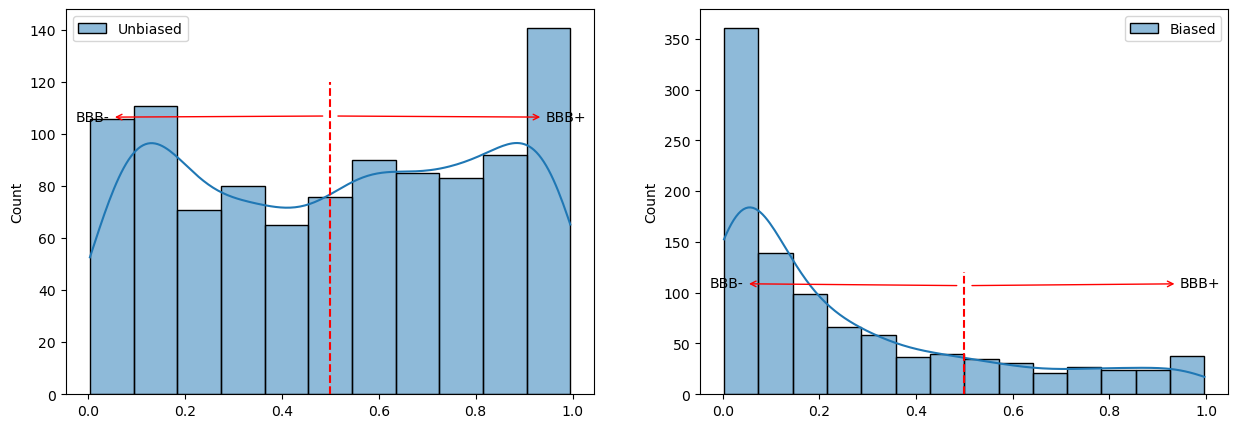

In [53]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
threshold = 0.5

sns.histplot(data=unbiased_results, kde=True, ax=ax[0], label='Unbiased')
ax[0].vlines(threshold,0,120,color='red', ls='--')
ax[0].annotate('BBB+',(threshold + 0.01,107), (ax[0].get_xlim()[1] - 0.1,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
ax[0].annotate('BBB-',(threshold - 0.01,107), (ax[0].get_xlim()[0] + 0.02,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );
ax[0].legend()

sns.histplot(data=biased_results, kde=True, ax=ax[1], label='Biased')
ax[1].vlines(threshold,0,120,color='red', ls='--')
ax[1].annotate('BBB+',(threshold + 0.01,107), (ax[1].get_xlim()[1] - 0.1,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} )
ax[1].annotate('BBB-',(threshold - 0.01,107), (ax[1].get_xlim()[0] + 0.02,105), arrowprops={'color':'red',
                                                              'arrowstyle':'<-','relpos':(.5,.5)} );
ax[1].legend();

We can classify the labels as BBB+/BBB- with:

In [54]:
biased_labels = ["BBB+" if x>=0.5 else "BBB-" for x in biased_results['CHEMBERT_predictor']]

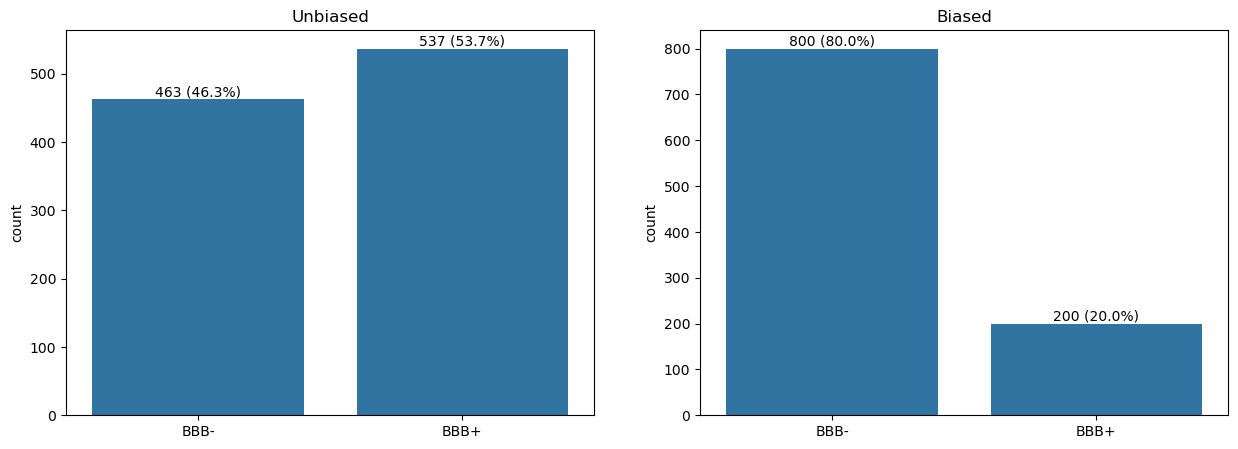

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

# Unbiased set
sns.countplot(x=unbiased_labels,order=['BBB-','BBB+'], ax=ax[0])
counts_unbiased=np.array([sum(np.array(unbiased_labels) == "BBB-"),sum(np.array(unbiased_labels) == "BBB+")])
rel_counts_unb = counts_unbiased / len(unbiased_labels)
labels_unb = [f"{l[0]} ({l[1]:0.1%})" for l in zip(counts_unbiased, rel_counts_unb)]

ax[0].bar_label(container=ax[0].containers[0], labels=labels_unb)
ax[0].set_title("Unbiased")
    
# Biased set
sns.countplot(x=biased_labels  ,order=['BBB-','BBB+'], ax=ax[1])
counts_biased=np.array([sum(np.array(biased_labels) == "BBB-"),sum(np.array(biased_labels) == "BBB+")])
rel_counts_bia = counts_biased / len(biased_labels)
labels_bia = [f"{l[0]} ({l[1]:0.1%})" for l in zip(counts_biased, rel_counts_bia)]
ax[1].bar_label(container=ax[1].containers[0], labels=labels_bia)
ax[1].set_title("Biased");



Here's a random sample of the molecules generated by the generator **_before_** biasing

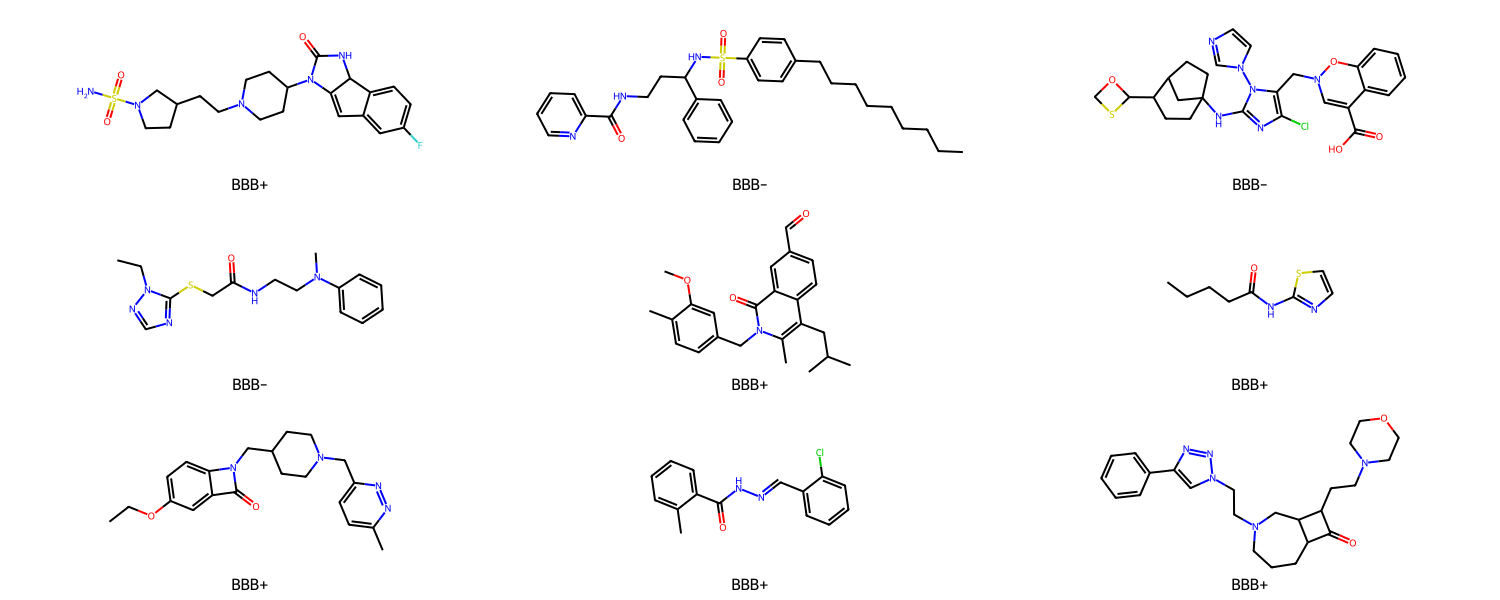

In [56]:
mols_idx =random.sample(range(len(unbiased_mols)), 9)
mols = [unbiased_mols[x] for x in mols_idx]
legends = [unbiased_labels[x] for x in mols_idx]
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200), legends=legends)

And here is a random sample of molecules generated **_after_** the biasing procedure:

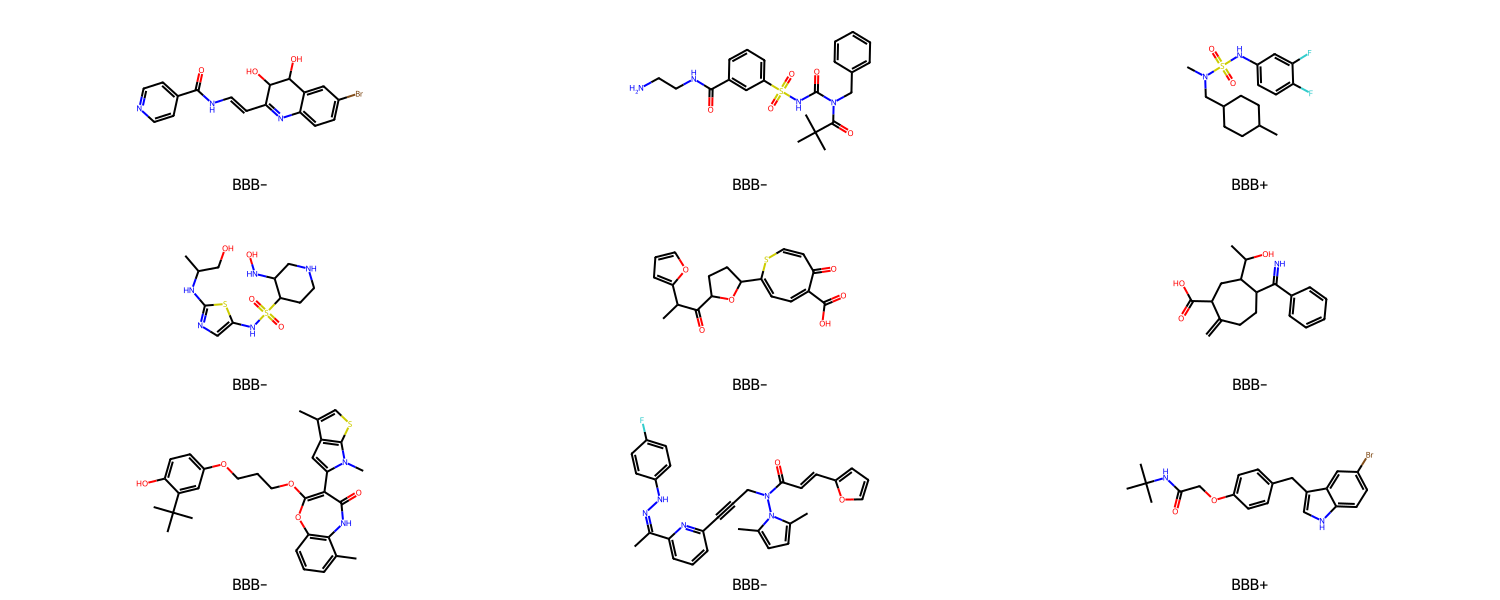

In [57]:
mols_idx =random.sample(range(len(biased_mols)), 9)
mols = [biased_mols[x] for x in mols_idx]
legends = [biased_labels[x] for x in mols_idx]
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(500,200), legends=legends)

# Conclusion

In [58]:
end_time = time.time()
elapsed_total = end_time - start_time

print(f"You took a total of {hms(elapsed_total)} to run the full notebook")

You took a total of 0.00 hours, 25.00 minutes and 57.57 seconds. to run the full notebook
